In [ ]:
import os, json, glob
import pandas as pd
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1) List all chunk directories you want to use
CHUNK_BASES = [
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk1",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk2",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk3",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk4",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk5",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk6",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk7",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk8",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk9",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk10"
    # add more here later if you create chunk4, chunk5, ...
]

LABELS_CSV = "/content/drive/MyDrive/DeepLearningProject/h/train.csv"

assert os.path.isfile(LABELS_CSV), LABELS_CSV

# 2) For each chunk: find its train folder + bags_chunk*.json
chunk_configs = []   # list of dicts: {seg_root, bags_json}
for base in CHUNK_BASES:
    seg_root = os.path.join(base, "train")
    assert os.path.isdir(seg_root), seg_root

    # auto-detect bags_chunkX.json inside the chunk folder
    cand = glob.glob(os.path.join(base, "bags_chunk*.json"))
    if len(cand) != 1:
        raise RuntimeError(f"Expected exactly 1 bags_chunk*.json in {base}, found {cand}")
    bags_json = cand[0]
    assert os.path.isfile(bags_json), bags_json

    chunk_configs.append({"seg_root": seg_root, "bags_json": bags_json})

print("Found chunk configs:")
for cc in chunk_configs:
    print(" -", cc["seg_root"], "|", os.path.basename(cc["bags_json"]))

# 3) Load and merge all bags + build stem -> seg_root mapping
bags = {}              # merged mapping: "train::stem" -> cells
stem_to_root = {}      # stem -> seg_root (so we know where .npy lives)

for cc in chunk_configs:
    seg_root = cc["seg_root"]
    bj = cc["bags_json"]
    with open(bj, "r") as f:
        part = json.load(f)

    print(f"Loaded {len(part)} bags from {bj}")
    for key, cells in part.items():
        # keys are like "train::000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0"
        split, stem = key.split("::", 1)

        if key in bags:
            print(f"[WARN] duplicate bag key {key}, overwriting previous entry")

        bags[key] = cells
        # if a stem appears in multiple chunks, last one wins (shouldn't happen)
        stem_to_root[stem] = seg_root

print("Total images in ALL chunks:", len(bags))
print("Total unique stems with seg_root:", len(stem_to_root))

# 4) Load HPA labels once
df_labels = pd.read_csv(LABELS_CSV)  # columns: ID, Label
df_labels.head()


Found chunk configs:
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk1/train | bags_chunk1.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk2/train | bags_chunk2.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk3/train | bags_chunk3.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk4/train | bags_chunk4.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk5/train | bags_chunk5.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk6/train | bags_chunk6.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk7/train | bags_chunk7.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk8/train | bags_chunk8.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk9/train | bags_chunk9.json
 - /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk10/train | bags_chunk10.json
Loaded 500 bags from /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk1/bags_chunk1.json

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [ ]:
import random
import torch.nn.functional as F

def domain_aware_augment(x: torch.Tensor) -> torch.Tensor:
    """
    x: (4, H, W) tensor with values roughly in [0,1].
    Spatial + intensity augmentations that make sense for fluorescence microscopy.
    """
    # Random horizontal flip
    if random.random() < 0.5:
        x = torch.flip(x, dims=[2])

    # Random vertical flip
    if random.random() < 0.5:
        x = torch.flip(x, dims=[1])

    # Random 90° rotations
    k = random.randint(0, 3)
    if k > 0:
        x = torch.rot90(x, k, dims=[1, 2])

    # Per-channel intensity scaling (simulate stain variability)
    scales = torch.empty(4).uniform_(0.8, 1.2).to(x.device)
    x = x * scales.view(4, 1, 1)

    # Small Gaussian noise
    if random.random() < 0.8:
        noise = torch.randn_like(x) * 0.02
        x = x + noise

    # Clamp
    x = torch.clamp(x, 0.0, 1.0)
    return x


In [ ]:
NUM_CLASSES = 19  # HPA protein classes

def parse_label_str(label_str: str, num_classes: int = NUM_CLASSES):
    """Convert '0|1|2' -> multi-hot vector."""
    y = np.zeros(num_classes, dtype=np.float32)
    if isinstance(label_str, str) and label_str.strip() != "":
        for t in label_str.split('|'):
            idx = int(t)
            if 0 <= idx < num_classes:
                y[idx] = 1.0
    return y

id_to_vec = {
    row["ID"]: parse_label_str(row["Label"])
    for _, row in df_labels.iterrows()
}


In [ ]:
# keys look like "train::000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0"
bag_keys = list(bags.keys())
print("Example bag key:", bag_keys[0])

pairs = []  # (key, stem, label_vec)
for key in bag_keys:
    split, stem = key.split("::", 1)
    if stem in id_to_vec:
        y = id_to_vec[stem]
        pairs.append((key, stem, y))

print("Num images with labels in this chunk:", len(pairs))

Example bag key: train::000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
Num images with labels in this chunk: 5000


In [ ]:
import random

# pairs = [(bag_key, stem, y_vec), ...]   # already built

# If you want exactly 5000 labeled images:
random.seed(42)
if len(pairs) > 5000:
    pairs = random.sample(pairs, 5000)

print("Using images (bags):", len(pairs))

from sklearn.model_selection import train_test_split
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
print("Train bags:", len(train_pairs))
print("Val bags:", len(val_pairs))


Using images (bags): 5000
Train bags: 4000
Val bags: 1000


In [ ]:

class HPABagDataset(Dataset):
    def __init__(self, bags_dict, pairs, stem_to_root, crop_size=224, pad=16, transform=None):
        """
        bags_dict: merged dict from all chunks: key -> list[cell dicts]
        pairs:     list of (bag_key, stem, label_vec)
        stem_to_root: dict[stem] -> path to folder where <stem>.npy lives
        """
        self.bags = bags_dict
        self.pairs = pairs
        self.stem_to_root = stem_to_root   # ✅ multi-chunk aware
        self.crop_size = crop_size
        self.pad = pad
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def _crop_cell(self, x4, bbox):
        """
        Safe cropping:
        - validates bbox
        - clips to image bounds
        - returns None if region is invalid / empty
        """
        if bbox is None or len(bbox) != 4:
            return None

        x1, y1, x2, y2 = bbox

        # ensure numeric + proper ordering
        try:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        except Exception:
            return None

        # enforce x1 < x2, y1 < y2
        if x2 <= x1 or y2 <= y1:
            return None

        H, W = x4.shape[1:]
        # pad + clip
        x1 = max(0, x1 - self.pad)
        y1 = max(0, y1 - self.pad)
        x2 = min(W - 1, x2 + self.pad)
        y2 = min(H - 1, y2 + self.pad)

        if x2 <= x1 or y2 <= y1:
            return None

        crop = x4[:, y1:y2+1, x1:x2+1]  # (C, h, w)
        if crop.size == 0:
            return None

        # make square + resize
        ch, hh, ww = crop.shape
        side = max(hh, ww)
        pad_y = side - hh
        pad_x = side - ww
        crop_sq = np.pad(
            crop,
            ((0, 0), (0, pad_y), (0, pad_x)),
            mode="constant"
        )

        out = np.zeros((ch, self.crop_size, self.crop_size), dtype=np.float32)
        for c in range(ch):
            out[c] = cv2.resize(
                crop_sq[c],
                (self.crop_size, self.crop_size),
                interpolation=cv2.INTER_AREA
            )
        return out

    def __getitem__(self, idx):
        bag_key, stem, y_vec = self.pairs[idx]

        # locate the correct chunk directory
        if stem not in self.stem_to_root:
            raise KeyError(f"Stem {stem} not found in stem_to_root (check chunk mapping).")
        seg_root = self.stem_to_root[stem]

        npy_path = os.path.join(seg_root, f"{stem}.npy")
        if not os.path.isfile(npy_path):
            raise FileNotFoundError(f"Missing .npy for stem {stem} at {npy_path}")

        x4 = np.load(npy_path).astype(np.float32)  # (4, H, W)

        cells = self.bags.get(bag_key, [])
        crops = []

        for cell in cells:
            bbox = cell.get("bbox_xyxy", None)
            crop = self._crop_cell(x4, bbox)
            if crop is None:
                continue  # skip bad cell

            if self.transform is not None:
                crop_t = torch.from_numpy(crop / 255.0)  # (C,H,W) in 0–1
                crop_t = self.transform(crop_t)
            else:
                crop_t = torch.from_numpy(crop / 255.0)

            crops.append(crop_t)

        # if no valid crops, create a single dummy crop
        if len(crops) == 0:
            dummy = torch.zeros(4, self.crop_size, self.crop_size, dtype=torch.float32)
            crops = [dummy]

        bag = torch.stack(crops, dim=0)  # (N_cells, 4, H, W)
        y = torch.from_numpy(y_vec.astype(np.float32))

        return bag, y, stem


In [ ]:
class HPACellDataset(Dataset):
    def __init__(
        self,
        bags_dict,
        pairs,
        stem_to_root,
        crop_size=224,
        pad=16,
        max_cells_per_bag=32,
        transform=None,
    ):
        self.bags = bags_dict
        self.stem_to_root = stem_to_root
        self.crop_size = crop_size
        self.pad = pad
        self.transform = transform

        self.samples = []  # list of (bag_key, stem, inst_idx, y_vec)

        for bag_key, stem, y_vec in pairs:
            instances = self.bags[bag_key]
            if len(instances) == 0:
                continue

            idxs = np.arange(len(instances))
            if len(idxs) > max_cells_per_bag:
                idxs = np.random.choice(idxs, max_cells_per_bag, replace=False)

            for inst_idx in idxs:
                self.samples.append((bag_key, stem, int(inst_idx), y_vec))

        print("Total cell samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        bag_key, stem, inst_idx, y_vec = self.samples[idx]
        instances = self.bags[bag_key]
        inst = instances[inst_idx]

        x0, y0, x1, y1 = inst["bbox_xyxy"]
        x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

        root = self.stem_to_root[stem]
        npy_path = os.path.join(root, f"{stem}.npy")
        img = np.load(npy_path)  # (4, H, W) or (H, W, 4)

        if img.ndim == 3 and img.shape[0] != 4 and img.shape[-1] == 4:
            img = np.transpose(img, (2, 0, 1))

        H, W = img.shape[1], img.shape[2]
        x0p = max(0, x0 - self.pad)
        y0p = max(0, y0 - self.pad)
        x1p = min(W, x1 + self.pad)
        y1p = min(H, y1 + self.pad)

        crop = img[:, y0p:y1p, x0p:x1p]  # (4, h, w)
        crop = torch.from_numpy(crop).float()

        if crop.max() > 1.5:
            crop = crop / crop.max()

        # resize to (4, crop_size, crop_size)
        crop = crop.unsqueeze(0)
        crop = F.interpolate(
            crop,
            size=(self.crop_size, self.crop_size),
            mode="bilinear",
            align_corners=False,
        ).squeeze(0)

        if self.transform is not None:
            crop = self.transform(crop)

        y = torch.from_numpy(y_vec.astype(np.float32))
        return crop, y


In [ ]:
from sklearn.model_selection import train_test_split

# Split your image-level pairs into 80% train / 20% val
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

print(f"Total labeled images (bags): {len(pairs)}")
print(f"Train pairs: {len(train_pairs)}")
print(f"Val pairs:   {len(val_pairs)}")


Total labeled images (bags): 5000
Train pairs: 4000
Val pairs:   1000


In [ ]:
from torch.utils.data import DataLoader

MAX_CELLS_PER_BAG = 16       # reduce loaded cells per image

# slice the training image-level pairs
cell_pairs = train_pairs

print("Using bags for weak supervision:", len(cell_pairs))

cell_train_dataset = HPACellDataset(
    bags_dict=bags,
    pairs=cell_pairs,
    stem_to_root=stem_to_root,
    crop_size=224,
    pad=16,
    max_cells_per_bag=MAX_CELLS_PER_BAG,
    transform=domain_aware_augment,     # ✅ AUG ENABLED FOR TRAIN
)

# ==================================================

cell_train_loader = DataLoader(
    cell_train_dataset,
    batch_size=16,             # small batch fits easily
    shuffle=True,
    num_workers=0,             # safe with Google Drive
    pin_memory=False,
)

print("Cell-level batches per epoch:", len(cell_train_loader))

# ================================================
val_cell_dataset = HPACellDataset(
    bags_dict=bags,
    pairs=val_pairs,
    stem_to_root=stem_to_root,
    crop_size=224,
    pad=16,
    max_cells_per_bag=MAX_CELLS_PER_BAG,
    transform=None,                   # no augmentation
)

val_loader = DataLoader(
    val_cell_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

print("Validation batches:", len(val_loader))

Using bags for weak supervision: 4000
Total cell samples: 61804
Cell-level batches per epoch: 3863
Total cell samples: 15450
Validation batches: 483


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

class ResNetBackbone(nn.Module):
    def __init__(self, in_channels=4, out_dim=2048):
        super().__init__()
        base = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # <-- pretrained

        old_conv = base.conv1
        new_conv = nn.Conv2d(
            in_channels,
            old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False,
        )

        with torch.no_grad():
            # copy original 3-channel weights
            new_conv.weight[:, :3] = old_conv.weight
            # initialize 4th channel as mean of RGB
            new_conv.weight[:, 3:4] = old_conv.weight.mean(dim=1, keepdim=True)

        base.conv1 = new_conv

        self.features = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
            base.layer1,
            base.layer2,
            base.layer3,
            base.layer4,
            base.avgpool,
        )
        self.out_dim = 2048

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class CellClassifier(nn.Module):
    def __init__(self, backbone, num_classes=NUM_CLASSES):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(backbone.out_dim, num_classes)

    def forward(self, x):
        feat = self.backbone(x)
        logits = self.classifier(feat)
        return logits


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Shared backbone
backbone = ResNetBackbone(in_channels=4, out_dim=2048).to(device)
cell_model = CellClassifier(backbone=backbone, num_classes=NUM_CLASSES).to(device)

# ----- Class imbalance handling (pos_weight) -----
Y = np.stack([y for _, _, y in pairs], axis=0)
pos_freq = Y.mean(axis=0) + 1e-6
neg_freq = 1.0 - pos_freq
pos_weight = torch.from_numpy(neg_freq / pos_freq).float().to(device)
print("pos_weight:", pos_weight)

cell_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
cell_optimizer = torch.optim.Adam(cell_model.parameters(), lr=1e-4)

# ---------- Helper: Evaluate Macro F1 ----------
def eval_cell_f1(model, loader, threshold=0.5):
    model.eval()
    all_y = []
    all_p = []

    with torch.no_grad():
        for crop, y in loader:
            crop = crop.to(device)
            y_np = y.numpy()

            logits = model(crop)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_y.append(y_np)
            all_p.append(preds)

    all_y = np.vstack(all_y)
    all_p = np.vstack(all_p)

    valid = all_y.sum(axis=0) > 0
    if valid.sum() == 0:
        return 0.0

    macro_f1 = f1_score(all_y[:, valid], all_p[:, valid],
                        average="macro", zero_division=0)
    return macro_f1


# =======================================================
# 📊 TRAINING LOOP WITH LOSS + F1 TRACKING
# =======================================================

CELL_EPOCHS = 3
LOG_EVERY = 100

loss_history = []
f1_history = []

for epoch in range(1, CELL_EPOCHS + 1):
    cell_model.train()
    running_loss = 0.0
    n_batches = 0

    print(f"\n===== Cell-level Epoch {epoch}/{CELL_EPOCHS} =====")
    pbar = tqdm(cell_train_loader)

    for step, (crop, y) in enumerate(pbar):
        crop = crop.to(device)
        y    = y.to(device)

        cell_optimizer.zero_grad()
        logits = cell_model(crop)
        loss = cell_criterion(logits, y)
        loss.backward()
        cell_optimizer.step()

        running_loss += loss.item()
        n_batches += 1

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / max(1, n_batches)
    loss_history.append(avg_loss)

    # ---- Evaluate macro F1 on validation ----
    val_f1 = eval_cell_f1(cell_model, val_loader)
    f1_history.append(val_f1)

    print(f"--> Epoch {epoch}: loss={avg_loss:.4f}, val_macro_F1={val_f1:.4f}")


# =======================================================
# 💾 Save final backbone
# =======================================================
BACKBONE_CKPT = "/content/drive/MyDrive/DeepLearningProject/h/cell_backboneV3.pt"
torch.save(backbone.state_dict(), BACKBONE_CKPT)
print(f"[CKPT] Saved backbone to {BACKBONE_CKPT}")


# =======================================================
# 📈 PLOTTING LOSS & F1 CURVES
# =======================================================
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(loss_history, marker='o')
plt.title("Cell-Level Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(f1_history, marker='o')
plt.title("Validation Macro F1")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")

plt.tight_layout()
plt.show()


Using device: cuda
pos_weight: tensor([  1.4950,  17.5182,   7.9126,  15.0254,  15.0254,  11.4377,  25.5950,
         10.9903,  21.7268,  22.6961,  24.5096, 237.0386,  11.9868,   5.6489,
         10.1357,  86.7116,   2.7119,  37.4601, 712.7759], device='cuda:0')

===== Cell-level Epoch 1/3 =====


100%|██████████| 3863/3863 [9:22:13<00:00,  8.73s/it, loss=1.1566]


--> Epoch 1: loss=1.2401, val_macro_F1=0.1827

===== Cell-level Epoch 2/3 =====


 15%|█▌        | 598/3863 [1:33:20<8:29:39,  9.37s/it, loss=1.3255]


KeyboardInterrupt: 

ds


Total bags loaded: 4500
Total unique stems: 4500
[WARN] Stem 5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0 not found, picking a random one.
Using stem: 000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0
Using npy_path: /content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk1/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.npy
Num cells in bag train::000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0: 31


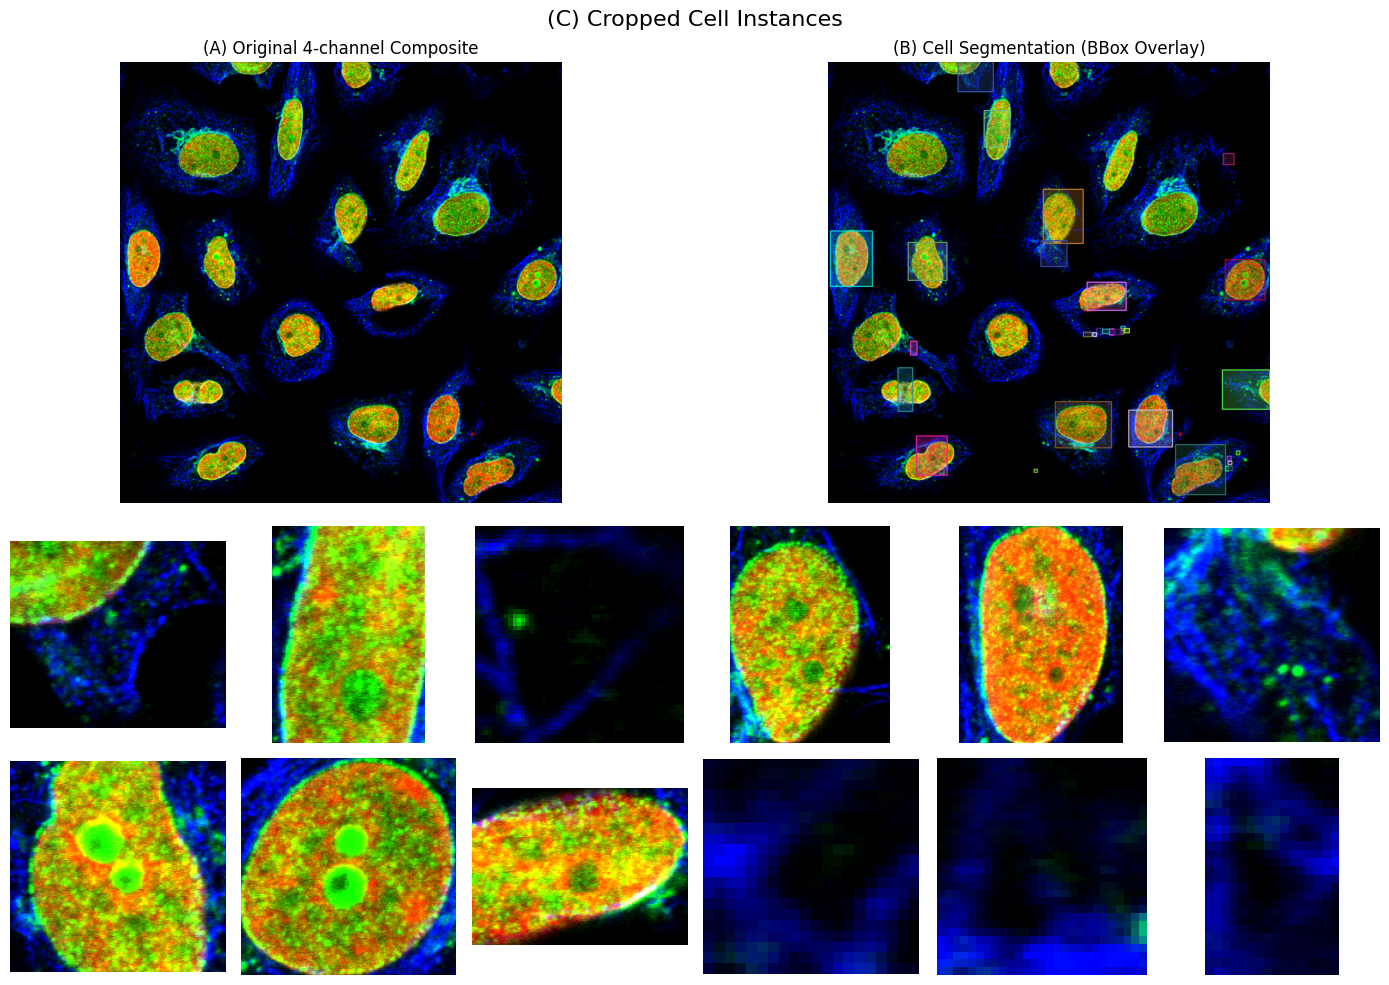

Saved Figure 1 to: /content/drive/MyDrive/DeepLearningProject/h/fig1_segmentation.png


In [ ]:
import os, json, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --------------------------
# 1) Rebuild bags + stem_to_root
# --------------------------
CHUNK_BASES = [
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk1",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk2",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk3",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk4",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk5",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk6",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk7",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk8",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk9",
    "/content/drive/MyDrive/DeepLearningProject/h/hpa_seg_chunk10",
]

bags = {}
stem_to_root = {}

for base in CHUNK_BASES:
    seg_root = os.path.join(base, "train")
    if not os.path.isdir(seg_root):
        print(f"[WARN] Missing seg_root: {seg_root}, skipping.")
        continue

    json_list = glob.glob(os.path.join(base, "bags_chunk*.json"))
    if len(json_list) != 1:
        print(f"[WARN] Expected exactly one bags_chunk*.json in {base}, found {json_list}")
        continue

    bags_json = json_list[0]
    with open(bags_json, "r") as f:
        part = json.load(f)

    for key, cells in part.items():
        bags[key] = cells
        split, stem = key.split("::", 1)
        stem_to_root[stem] = seg_root

print(f"Total bags loaded: {len(bags)}")
print(f"Total unique stems: {len(stem_to_root)}")

# --------------------------
# 2) Choose a stem to visualize
# --------------------------
stem = "5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0"

if stem not in stem_to_root:
    # fall back to some random stem
    print(f"[WARN] Stem {stem} not found, picking a random one.")
    stem = list(stem_to_root.keys())[0]
    print("Using stem:", stem)

seg_root = stem_to_root[stem]
npy_path = os.path.join(seg_root, f"{stem}.npy")
print("Using npy_path:", npy_path)

assert os.path.isfile(npy_path), f"Missing npy file: {npy_path}"

# --------------------------
# 3) Load 4-channel image
# --------------------------
x4 = np.load(npy_path).astype(np.float32)  # (4,H,W)
assert x4.shape[0] == 4, f"Expected 4 channels, got {x4.shape}"

B, G, R, Y = x4

# (A) Composite RGB image for visualization
rgb_composite = np.stack([R, G, B], axis=-1)  # (H,W,3)
max_val = rgb_composite.max()
if max_val > 0:
    rgb_composite = (rgb_composite / max_val).clip(0, 1)
else:
    rgb_composite = np.zeros_like(rgb_composite)

# --------------------------
# 4) Build approximate "mask" from bounding boxes
# --------------------------
bag_key = f"train::{stem}"
cells = bags.get(bag_key, [])
print(f"Num cells in bag {bag_key}: {len(cells)}")

H, W = B.shape
# --------------------------
# Improved segmentation overlay
# --------------------------

overlay = (rgb_composite * 255).astype(np.uint8).copy()
mask_overlay = overlay.copy()

for i, cell in enumerate(cells, start=1):
    bbox = cell.get("bbox_xyxy", None)
    if bbox is None:
        continue

    x1, y1, x2, y2 = map(int, bbox)
    x1 = max(0, min(W-1, x1))
    x2 = max(0, min(W-1, x2))
    y1 = max(0, min(H-1, y1))
    y2 = max(0, min(H-1, y2))
    if x2 <= x1 or y2 <= y1:
        continue

    # bright, high-contrast colors
    color = (
        int((i * 53) % 256),
        int((i * 97) % 256),
        int((i * 199) % 256)
    )

    # (1) Draw thick bounding box
    cv2.rectangle(mask_overlay, (x1, y1), (x2, y2), color, thickness=3)

    # (2) Fill inside with translucent color
    fill_color = np.array(color, dtype=np.uint8)
    alpha = 0.25  # transparency

    mask_overlay[y1:y2, x1:x2] = (
        alpha * fill_color + (1-alpha) * mask_overlay[y1:y2, x1:x2]
    ).astype(np.uint8)

# --------------------------
# 5) Extract cropped cell examples (first up to 12)
# --------------------------
crop_examples = []
for cell in cells[:12]:
    bbox = cell.get("bbox_xyxy", None)
    if bbox is None:
        continue
    x1, y1, x2, y2 = map(int, bbox)
    x1 = max(0, min(W - 1, x1))
    x2 = max(0, min(W - 1, x2))
    y1 = max(0, min(H - 1, y1))
    y2 = max(0, min(H - 1, y2))
    if x2 <= x1 or y2 <= y1:
        continue

    crop = x4[:, y1:y2, x1:x2]  # (4,h,w)
    if crop.size == 0:
        continue
    cB, cG, cR, cY = crop
    crop_rgb = np.stack([cR, cG, cB], axis=-1)
    cmax = crop_rgb.max()
    if cmax > 0:
        crop_rgb = (crop_rgb / cmax).clip(0, 1)
    else:
        crop_rgb = np.zeros_like(crop_rgb)
    crop_examples.append(crop_rgb)

if len(crop_examples) == 0:
    print("[WARN] No valid crops found, creating dummy black crops.")
    crop_examples = [np.zeros((64, 64, 3), dtype=np.float32)]

while len(crop_examples) < 12:
    crop_examples.append(np.zeros_like(crop_examples[0]))

# --------------------------
# 6) Plot Figure 1 and save
# --------------------------
fig = plt.figure(figsize=(14, 10))

# (A) Original composite
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(rgb_composite)
ax1.set_title("(A) Original 4-channel Composite")
ax1.axis("off")

# (B) Segmentation (bbox overlay)
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(mask_overlay)
ax2.set_title("(B) Cell Segmentation (BBox Overlay)")
ax2.axis("off")

# (C) Cropped cell instances grid
for i in range(12):
    ax = fig.add_subplot(4, 6, 12 + i + 1)
    ax.imshow(crop_examples[i])
    ax.axis("off")

fig.suptitle("(C) Cropped Cell Instances", fontsize=16)

plt.tight_layout()
out_path = "/content/drive/MyDrive/DeepLearningProject/h/fig1_segmentation.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved Figure 1 to:", out_path)
